In [1]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass
assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

if not (shutil.which("glpsol") or os.path.isfile("glpsol")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge glpk
        except:
            pass
assert(shutil.which("glpsol") or os.path.isfile("glpsol"))

import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

# Fundamentos de Pyomo
Pyomo (Python Optimization Modeling Objects) es una biblioteca de código abierto en Python que se utiliza para definir y resolver problemas complejos de optimización matemática.

Los requisitos para utilizar Pyomo son:
1. Tener instalado Python $\geq$ 3.6
2. Instalar Pyomo ([instrucciones](https://pyomo.readthedocs.io/en/stable/getting_started/installation.html))
    ```python
    pip install pyomo
    ```
3. Instalar los *solvers* necesarios ([solvers disponibles](https://pyomo.readthedocs.io/en/stable/getting_started/solvers.html))

# Ejemplo 1: problema teórico

Resuelve el siguiente problema de optimización no lineal (NLP) con restricciones utilizando Pyomo.

$$\begin{align*} \min_{x} \quad & x_1^2 + 2 x_2^2 - x_3 \\
\mathrm{s.t.} \quad & x_1 + x_2 = 1 \\
& x_1 + 2 x_2 - x_3 = 5 \\
& -10 \leq x_1, x_2, x_3 \leq 10
\end{align*} $$

## Paso I: Implementación del modelo

Declarar el modelo que se va resolver consiste en definir el tipo de modelo que se va a utilizar ([abstracto o concreto](https://pyomo.readthedocs.io/en/stable/getting_started/pyomo_overview/abstract_concrete.html)), los conjuntos, las variables de decisión, los parámetros, las restricciones y la función objetivo del problema.

Puedes encontrar instrucciones sobre cómo hacerlo en el [este enlace](https://pyomo.readthedocs.io/en/stable/explanation/modeling/math_programming/sets.html). Con esa información, completa el siguiente código:

In [3]:
# En este caso, utiliza un modelo concreto
model = pyo.ConcreteModel()

## Declara las variables del problema, indicando:
## - Límites inferior y superior
## - Punto de partida para inicializar el algoritmo de optimización
model.x1 = pyo.Var(initialize=1, bounds=(-10, 10))
model.x2 = pyo.Var(initialize=1, bounds=(-10, 10))
model.x3 = pyo.Var(initialize=1, bounds=(-10, 10))

## Declara la función objetivo
model.obj = pyo.Objective(expr = model.x1**2 + 2*model.x2**2 - model.x3,
                      sense = "minimize")

## Declara las restricciones de igualdad
model.h1 = pyo.Constraint(expr = model.x1 + model.x2 == 1)
model.h2 = pyo.Constraint(expr = model.x1 + 2*model.x2 - model.x3 == 5)

La función *pprint* permite visualizar el modelo completo o alguno de sus componentes.

In [4]:
model.pprint()

3 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
    x3 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : x1**2 + 2*x2**2 - x3

2 Constraint Declarations
    h1 : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :   1.0 : x1 + x2 :   1.0 :   True
    h2 : Size=1, Index=None, Active=True
        Key  : Lower : Body           : Upper : Active
        None :   5.0 : x1 + 2*x2 - x3 :   5.0 :   True

6 Declarations: x1 x2 x3 obj h1 h2


In [5]:
model.x1.pprint()

x1 : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :   -10 :     1 :    10 : False : False :  Reals


## Paso II: Resolución del modelo
Una vez definido el problema, ya solo se faltaría seleccionar el *solver* apropiado  y resolver. El comando ```pyomo help --solvers``` resulta muy útil para listar todos los *solvers* soportados por pyomo.

El algoritmo de resolución se invoca con la orden ```SolverFactory(solver_name)```, donde solver *solver_name* debe ser un dato de tipo cadena (string). En este caso, se va a utilizar el [IPOPT](https://github.com/coin-or/Ipopt/blob/stable/3.14/README.md).

In [6]:
# Selecciona el solver
solver = pyo.SolverFactory("ipopt")
# Resuelve el problema
results = solver.solve(model, tee=True) # tee = True muestra el output del solver

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        5
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Tot

## Paso III: Inspección de la solución

La función *value* se utiliza para extraer el valor numérico de una variable de Pyomo.

In [13]:
print(f"Función objetivo: {model.obj()}")
print(f"x1 = {model.x1.value:.2f}",)
print(f"x2 = {model.x2.value:.2f}")
print(f"x3 = {model.x3.value:.2f}")

Objetivo: 4.25
x1 = 0.50
x2 = 0.50
x3 = -3.50


Para este sencillo ejemplo, se puede visualizar si la solución obtenida es correcta ejecutando el siguiente código:

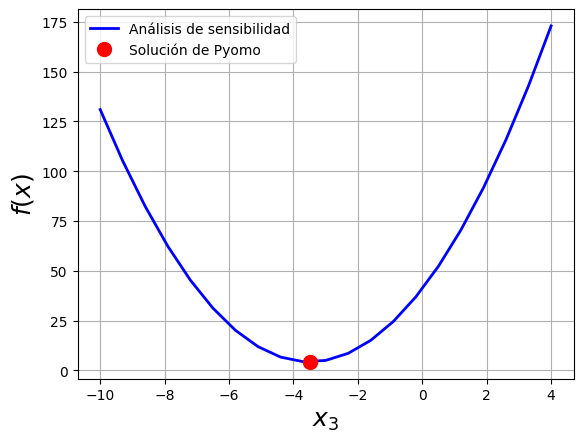

In [15]:
def restricciones(x3):
    ''' Resuelve el sistema de ecuaciones formado por las restricciones del problema

    Args:
        x3: Valor de la variable x3

    Returns:
        x1 and x2: Valor calculado para las variables x1 y x2
    '''
    # Coeficientes del sistema de ecuaciones lineales Ax=b
    # donde x={x1,x2} y x3 actúa como un parámetro
    A = np.array([[1, 1],[1, 2]])
    b = np.array([1, 5+x3])

    # Resolución del sistema
    z = np.linalg.solve(A,b)
    x1 = z[0]
    x2 = z[1]
    return x1, x2

# Función objetivo
objective = lambda x1, x2, x3: x1**2 + 2*x2**2 - x3

# Rango de valores que x3 puede tomar
x3_guesses = np.linspace(-10,4,21)
obj = []
for x3 in x3_guesses:
    # Resolver el sistema de ecuaciónes para obtener x1 y x2
    x1, x2 = restricciones(x3)
    # Calcular y guardar la función objetivo para cada combinación
    obj.append(objective(x1,x2,x3))

# Representar el valor de la fución objetivo con respecto a x3
plt.plot(x3_guesses, obj,color='blue',linewidth=2,label="Análisis de sensibilidad")
plt.xlabel("$x_3$",fontsize=18)
plt.ylabel("$f(x)$",fontsize=18)
x3_sln = model.x3.value
obj_sln = model.obj()
plt.plot(x3_sln, obj_sln,marker='o',color='red',markersize=10,label="Solución de Pyomo",linestyle='')
plt.legend()
plt.grid(True)
plt.show()

# Ejemplo 2: problema de mezcla lineal

Imagina que trabajas como ingeniero de procesos para una cervecería, donde de tus responsabilidades consiste en planificar la producción.

Habeís recibido un pedido de **100 litros** de cerveza, cuya graduación debe ser del **4% de alcohol por volumen**. Sin embargo, la cervecería tiene solo dos líneas de producción: la **cerveza A** tiene un porcentaje de alcohol del **4.5%** y un coste de producción **0.32 €/m3** mientras que la **cerveza B** de **3.7%** tiene unos costes de producción **0.25 €/m3**.

Una posible solución consiste en mezclar ambos tipos de cerveza hasta obtener la graduación deseada. Además, como alternativa, se puede utilizar **agua** como agente de mezcla con un coste de **0.05 €/m3**.

Tu tarea es encontrar la mezcla de coste mínimo que cumpla las especificaciones del cliente.

Escribe **EN PAPEL** el problema de optimización y utiliza esa formulación para resolver el modelo en Pyomo.

In [16]:
# Modelo
m = pyo.ConcreteModel()

# Sets
m.C = pyo.Set( initialize = ['A','B','C'], doc = 'Components')

# Variables
m.x = pyo.Var(m.C, within=pyo.NonNegativeReals, doc = 'Volumen m3')

# Parámetros
m.P = pyo.Param(m.C, initialize = {'A': 0.32, 'B': 0.25, 'C': 0.05}, doc = 'Coste €/m3')
m.apv = pyo.Param( m.C, initialize = {'A': 4.5, 'B': 3.7, 'C': 0.}, doc = 'Graduación')
m.V = pyo.Param(initialize = 100., doc = 'Demanda m3')
m.apv_spec = pyo.Param(initialize = 4., doc = 'Graduación deseada')

# Función objetivo
m.obj = pyo.Objective(expr = sum(m.x[c]*m.P[c]for c in m.C), sense=pyo.minimize)

# Restricciones
## Satisfacción de la demanda
m.con_demand = pyo.Constraint(expr = m.V == sum(m.x[c] for c in m.C))
## Composición del producto
m.con_spec = pyo.Constraint(expr = 0 == sum(m.x[c]*(m.apv[c] - m.apv_spec) for c in m.C))

Al tratarse de un problema lineal (LP), el *solver* que se va a utilizar es [GLPK (GNU Linear Programming Kit)](https://www.gnu.org/software/glpk/).

In [17]:
optimizer = pyo.SolverFactory('glpk')
results = optimizer.solve(m)

Ejecuta la siguiente celda para visualizar la solución:

In [18]:
print('Mezcla óptima')
for c in m.C:
    print(f'  {c}:{m.x[c]()} L')
print()
print(f'Volumen = {m.V()} L')
print(f'Coste = {m.obj()} €')
print('\nSolver status: {results.solver.status}')
print('\nTerminación: {results.solver.termination_condition}')

Mezcla óptima
  A:37.5 L
  B:62.5 L
  C:0.0 L

Volumen = 100.0 L
Coste = 27.625 €

Solver status: {results.solver.status}

Terminación: {results.solver.termination_condition}
